In \[1\]:

    %matplotlib inline
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

In \[2\]:

    # loading the ratings dataset : 
    ratings = pd.read_csv('ratings_small.csv')
    ratings.head()

Out\[2\]:

|     | userId | movieId | rating | timestamp  |
|-----|--------|---------|--------|------------|
| 0   | 1      | 31      | 2.5    | 1260759144 |
| 1   | 1      | 1029    | 3.0    | 1260759179 |
| 2   | 1      | 1061    | 3.0    | 1260759182 |
| 3   | 1      | 1129    | 2.0    | 1260759185 |
| 4   | 1      | 1172    | 4.0    | 1260759205 |

In \[3\]:

    print( "Total Number of Movies : ",ratings['movieId'].unique().shape[0])
    print( "Total Number of Users : ",ratings['userId'].unique().shape[0])

    Total Number of Movies :  9066
    Total Number of Users :  671

Attempting to understand Matrix Factorisation :<a href="#Attempting-to-understand-Matrix-Factorisation-:" class="anchor-link">¶</a>
===================================================================================================================================

In \[4\]:

    um_matrix = pd.DataFrame( columns = ratings['movieId'].unique(), index = ratings['userId'].unique())

In \[5\]:

    um_matrix.shape

Out\[5\]:

    (671, 9066)

In \[6\]:

    for index,row in ratings.iterrows():
        um_matrix.loc[ int(row['userId']), int(row['movieId']) ] = row['rating']

In \[7\]:

    um_matrix.head()

Out\[7\]:

|     | 31  | 1029 | 1061 | 1129 | 1172 | 1263 | 1287 | 1293 | 1339 | 1343 | ... | 134528 | 134783 | 137595 | 138204 | 60832 | 64997 | 72380 | 129 | 4736 | 6425 |
|-----|-----|------|------|------|------|------|------|------|------|------|-----|--------|--------|--------|--------|-------|-------|-------|-----|------|------|
| 1   | 2.5 | 3    | 3    | 2    | 4    | 2    | 2    | 2    | 3.5  | 2    | ... | NaN    | NaN    | NaN    | NaN    | NaN   | NaN   | NaN   | NaN | NaN  | NaN  |
| 2   | NaN | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | ... | NaN    | NaN    | NaN    | NaN    | NaN   | NaN   | NaN   | NaN | NaN  | NaN  |
| 3   | NaN | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | ... | NaN    | NaN    | NaN    | NaN    | NaN   | NaN   | NaN   | NaN | NaN  | NaN  |
| 4   | NaN | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | ... | NaN    | NaN    | NaN    | NaN    | NaN   | NaN   | NaN   | NaN | NaN  | NaN  |
| 5   | NaN | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | NaN  | ... | NaN    | NaN    | NaN    | NaN    | NaN   | NaN   | NaN   | NaN | NaN  | NaN  |

5 rows × 9066 columns

In \[8\]:

    print( f" empty cells in the matrix : { (um_matrix.isna().sum().sum() / (um_matrix.shape[0] * um_matrix.shape[1]))*100} %" )

     empty cells in the matrix : 98.35608583913366 %

Some EDA on Movie Ratings :<a href="#Some-EDA-on-Movie-Ratings-:" class="anchor-link">¶</a>
===========================================================================================

------------------------------------------------------------------------

In \[9\]:

    plt.figure(figsize = (12, 8))
    ax = sns.countplot(x="rating", data=ratings)

    plt.tick_params(labelsize = 15)
    plt.title("Distribution of Ratings in train data", fontsize = 20)
    plt.xlabel("Ratings", fontsize = 20)
    plt.ylabel("Number of Ratings", fontsize = 20)
    plt.show()

![](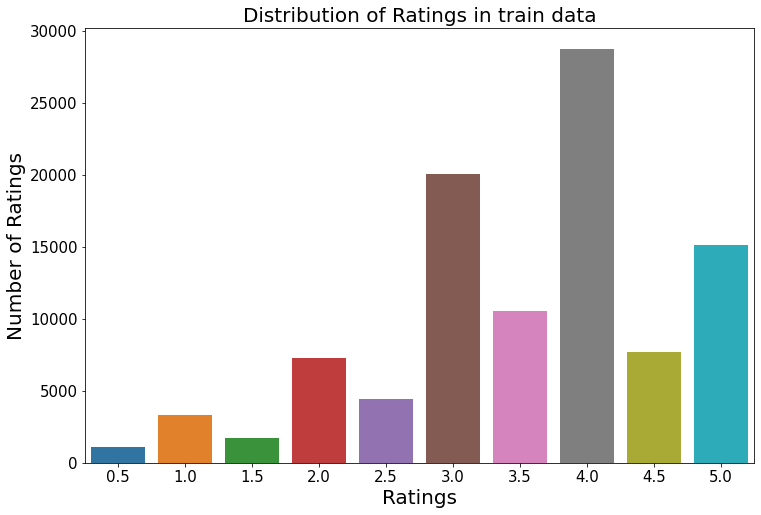%0A)

**Calculating average rating for each movie**

In \[10\]:

    avg_rating = ratings.groupby('movieId').mean()['rating']
    avg_rating.name = 'avg_rating'
    avg_rating

Out\[10\]:

    movieId
    1         3.872470
    2         3.401869
    3         3.161017
    4         2.384615
    5         3.267857
                ...   
    161944    5.000000
    162376    4.500000
    162542    5.000000
    162672    3.000000
    163949    5.000000
    Name: avg_rating, Length: 9066, dtype: float64

------------------------------------------------------------------------

**We also need the how many ratings each movie had**

\[ a movie with only a single rating of 5 will have a average rating of
5, which is misleading \]

In \[11\]:

    num_rating = ratings['movieId'].value_counts()
    num_rating.name = 'num_of_ratings'
    num_rating = num_rating.sort_index()

In \[12\]:

    num_rating

Out\[12\]:

    1         247
    2         107
    3          59
    4          13
    5          56
             ... 
    161944      1
    162376      1
    162542      1
    162672      1
    163949      1
    Name: num_of_ratings, Length: 9066, dtype: int64

------------------------------------------------------------------------

**Merging both average-rating and number-of-ratings column into a single
dataframe**

In \[13\]:

    rating_per_movie = pd.merge( avg_rating, num_rating, right_index = True, left_index = True)

In \[14\]:

    rating_per_movie.head()

Out\[14\]:

avg\_rating

num\_of\_ratings

movieId

1

3.872470

247

2

3.401869

107

3

3.161017

59

4

2.384615

13

5

3.267857

56

------------------------------------------------------------------------

**Plotting a scatter plot between avg\_rating and num\_of\_ratings :**

In \[15\]:

    sns.scatterplot(x='avg_rating', y='num_of_ratings', data=rating_per_movie)

Out\[15\]:

    <matplotlib.axes._subplots.AxesSubplot at 0x2cf837b6610>

![](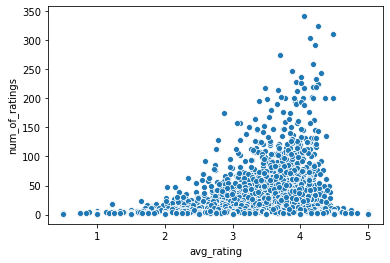%0A)

### We can observe that the movies at the top right space of the graph must be the popular movies :<a href="#We-can-observe-that-the-movies-at-the-top-right-space-of-the-graph-must-be-the-popular-movies-:" class="anchor-link">¶</a>

In \[16\]:

    most_popular_movies = rating_per_movie[ (rating_per_movie['avg_rating'] > 3.5) & (rating_per_movie['num_of_ratings'] > 200)].index

In \[17\]:

    # This dataset needs to be loaded for extracting the movie title :
    movies = pd.read_csv('movies.csv')
    movies.head()

Out\[17\]:

|     | movieId | title                              | genres                                          |
|-----|---------|------------------------------------|-------------------------------------------------|
| 0   | 1       | Toy Story (1995)                   | Adventure\|Animation\|Children\|Comedy\|Fantasy |
| 1   | 2       | Jumanji (1995)                     | Adventure\|Children\|Fantasy                    |
| 2   | 3       | Grumpier Old Men (1995)            | Comedy\|Romance                                 |
| 3   | 4       | Waiting to Exhale (1995)           | Comedy\|Drama\|Romance                          |
| 4   | 5       | Father of the Bride Part II (1995) | Comedy                                          |

In \[18\]:

    # A helper dictionary that maps the Movie Id and Movie Titles
    movie_id_to_title_map = {}

    for m_id , title in zip(movies['movieId'].values , movies['title'].values):
        movie_id_to_title_map[str(m_id)] = title

    movie_id_to_title_map

Out\[18\]:

    {'1': 'Toy Story (1995)',
     '2': 'Jumanji (1995)',
     '3': 'Grumpier Old Men (1995)',
     '4': 'Waiting to Exhale (1995)',
     '5': 'Father of the Bride Part II (1995)',
     '6': 'Heat (1995)',
     '7': 'Sabrina (1995)',
     '8': 'Tom and Huck (1995)',
     '9': 'Sudden Death (1995)',
     '10': 'GoldenEye (1995)',
     '11': 'American President, The (1995)',
     '12': 'Dracula: Dead and Loving It (1995)',
     '13': 'Balto (1995)',
     '14': 'Nixon (1995)',
     '15': 'Cutthroat Island (1995)',
     '16': 'Casino (1995)',
     '17': 'Sense and Sensibility (1995)',
     '18': 'Four Rooms (1995)',
     '19': 'Ace Ventura: When Nature Calls (1995)',
     '20': 'Money Train (1995)',
     '21': 'Get Shorty (1995)',
     '22': 'Copycat (1995)',
     '23': 'Assassins (1995)',
     '24': 'Powder (1995)',
     '25': 'Leaving Las Vegas (1995)',
     '26': 'Othello (1995)',
     '27': 'Now and Then (1995)',
     '28': 'Persuasion (1995)',
     '29': 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
     '30': 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
     '31': 'Dangerous Minds (1995)',
     '32': 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
     '34': 'Babe (1995)',
     '36': 'Dead Man Walking (1995)',
     '38': 'It Takes Two (1995)',
     '39': 'Clueless (1995)',
     '40': 'Cry, the Beloved Country (1995)',
     '41': 'Richard III (1995)',
     '42': 'Dead Presidents (1995)',
     '43': 'Restoration (1995)',
     '44': 'Mortal Kombat (1995)',
     '45': 'To Die For (1995)',
     '46': 'How to Make an American Quilt (1995)',
     '47': 'Seven (a.k.a. Se7en) (1995)',
     '48': 'Pocahontas (1995)',
     '49': 'When Night Is Falling (1995)',
     '50': 'Usual Suspects, The (1995)',
     '52': 'Mighty Aphrodite (1995)',
     '53': 'Lamerica (1994)',
     '54': 'Big Green, The (1995)',
     '55': 'Georgia (1995)',
     '57': 'Home for the Holidays (1995)',
     '58': 'Postman, The (Postino, Il) (1994)',
     '60': 'Indian in the Cupboard, The (1995)',
     '61': 'Eye for an Eye (1996)',
     '62': "Mr. Holland's Opus (1995)",
     '63': "Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)",
     '64': 'Two if by Sea (1996)',
     '65': 'Bio-Dome (1996)',
     '66': 'Lawnmower Man 2: Beyond Cyberspace (1996)',
     '68': 'French Twist (Gazon maudit) (1995)',
     '69': 'Friday (1995)',
     '70': 'From Dusk Till Dawn (1996)',
     '71': 'Fair Game (1995)',
     '72': 'Kicking and Screaming (1995)',
     '73': 'Misérables, Les (1995)',
     '74': 'Bed of Roses (1996)',
     '75': 'Big Bully (1996)',
     '76': 'Screamers (1995)',
     '77': 'Nico Icon (1995)',
     '78': 'Crossing Guard, The (1995)',
     '79': 'Juror, The (1996)',
     '80': 'White Balloon, The (Badkonake sefid) (1995)',
     '81': "Things to Do in Denver When You're Dead (1995)",
     '82': "Antonia's Line (Antonia) (1995)",
     '83': 'Once Upon a Time... When We Were Colored (1995)',
     '85': 'Angels and Insects (1995)',
     '86': 'White Squall (1996)',
     '87': 'Dunston Checks In (1996)',
     '88': 'Black Sheep (1996)',
     '89': 'Nick of Time (1995)',
     '92': 'Mary Reilly (1996)',
     '93': 'Vampire in Brooklyn (1995)',
     '94': 'Beautiful Girls (1996)',
     '95': 'Broken Arrow (1996)',
     '96': 'In the Bleak Midwinter (1995)',
     '97': 'Hate (Haine, La) (1995)',
     '99': 'Heidi Fleiss: Hollywood Madam (1995)',
     '100': 'City Hall (1996)',
     '101': 'Bottle Rocket (1996)',
     '102': 'Mr. Wrong (1996)',
     '103': 'Unforgettable (1996)',
     '104': 'Happy Gilmore (1996)',
     '105': 'Bridges of Madison County, The (1995)',
     '106': 'Nobody Loves Me (Keiner liebt mich) (1994)',
     '107': 'Muppet Treasure Island (1996)',
     '108': 'Catwalk (1996)',
     '110': 'Braveheart (1995)',
     '111': 'Taxi Driver (1976)',
     '112': 'Rumble in the Bronx (Hont faan kui) (1995)',
     '113': 'Before and After (1996)',
     '116': 'Anne Frank Remembered (1995)',
     '117': "Young Poisoner's Handbook, The (1995)",
     '118': 'If Lucy Fell (1996)',
     '119': 'Steal Big, Steal Little (1995)',
     '121': 'Boys of St. Vincent, The (1992)',
     '122': 'Boomerang (1992)',
     '123': 'Chungking Express (Chung Hing sam lam) (1994)',
     '125': 'Flirting With Disaster (1996)',
     '126': 'NeverEnding Story III, The (1994)',
     '128': "Jupiter's Wife (1994)",
     '129': 'Pie in the Sky (1996)',
     '132': 'Jade (1995)',
     '135': 'Down Periscope (1996)',
     '137': 'Man of the Year (1995)',
     '140': 'Up Close and Personal (1996)',
     '141': 'Birdcage, The (1996)',
     '144': 'Brothers McMullen, The (1995)',
     '145': 'Bad Boys (1995)',
     '146': 'Amazing Panda Adventure, The (1995)',
     '147': 'Basketball Diaries, The (1995)',
     '148': 'Awfully Big Adventure, An (1995)',
     '149': 'Amateur (1994)',
     '150': 'Apollo 13 (1995)',
     '151': 'Rob Roy (1995)',
     '152': 'Addiction, The (1995)',
     '153': 'Batman Forever (1995)',
     '154': 'Beauty of the Day (Belle de jour) (1967)',
     '155': 'Beyond Rangoon (1995)',
     '156': 'Blue in the Face (1995)',
     '157': 'Canadian Bacon (1995)',
     '158': 'Casper (1995)',
     '159': 'Clockers (1995)',
     '160': 'Congo (1995)',
     '161': 'Crimson Tide (1995)',
     '162': 'Crumb (1994)',
     '163': 'Desperado (1995)',
     '164': 'Devil in a Blue Dress (1995)',
     '165': 'Die Hard: With a Vengeance (1995)',
     '166': 'Doom Generation, The (1995)',
     '168': 'First Knight (1995)',
     '169': 'Free Willy 2: The Adventure Home (1995)',
     '170': 'Hackers (1995)',
     '171': 'Jeffrey (1995)',
     '172': 'Johnny Mnemonic (1995)',
     '173': 'Judge Dredd (1995)',
     '174': 'Jury Duty (1995)',
     '175': 'Kids (1995)',
     '176': 'Living in Oblivion (1995)',
     '177': 'Lord of Illusions (1995)',
     '178': 'Love & Human Remains (1993)',
     '179': 'Mad Love (1995)',
     '180': 'Mallrats (1995)',
     '181': 'Mighty Morphin Power Rangers: The Movie (1995)',
     '183': 'Mute Witness (1994)',
     '184': 'Nadja (1994)',
     '185': 'Net, The (1995)',
     '186': 'Nine Months (1995)',
     '187': 'Party Girl (1995)',
     '188': 'Prophecy, The (1995)',
     '189': 'Reckless (1995)',
     '190': 'Safe (1995)',
     '191': 'Scarlet Letter, The (1995)',
     '193': 'Showgirls (1995)',
     '194': 'Smoke (1995)',
     '195': 'Something to Talk About (1995)',
     '196': 'Species (1995)',
     '198': 'Strange Days (1995)',
     '199': 'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)',
     '201': 'Three Wishes (1995)',
     '202': 'Total Eclipse (1995)',
     '203': 'To Wong Foo, Thanks for Everything! Julie Newmar (1995)',
     '204': 'Under Siege 2: Dark Territory (1995)',
     '205': 'Unstrung Heroes (1995)',
     '206': 'Unzipped (1995)',
     '207': 'Walk in the Clouds, A (1995)',
     '208': 'Waterworld (1995)',
     '209': "White Man's Burden (1995)",
     '210': 'Wild Bill (1995)',
     '211': 'Browning Version, The (1994)',
     '212': 'Bushwhacked (1995)',
     '213': 'Burnt by the Sun (Utomlyonnye solntsem) (1994)',
     '214': 'Before the Rain (Pred dozhdot) (1994)',
     '215': 'Before Sunrise (1995)',
     '216': 'Billy Madison (1995)',
     '217': 'Babysitter, The (1995)',
     '218': 'Boys on the Side (1995)',
     '219': 'Cure, The (1995)',
     '220': 'Castle Freak (1995)',
     '222': 'Circle of Friends (1995)',
     '223': 'Clerks (1994)',
     '224': 'Don Juan DeMarco (1995)',
     '225': 'Disclosure (1994)',
     '227': 'Drop Zone (1994)',
     '228': 'Destiny Turns on the Radio (1995)',
     '229': 'Death and the Maiden (1994)',
     '230': 'Dolores Claiborne (1995)',
     '231': 'Dumb & Dumber (Dumb and Dumber) (1994)',
     '232': 'Eat Drink Man Woman (Yin shi nan nu) (1994)',
     '233': 'Exotica (1994)',
     '234': 'Exit to Eden (1994)',
     '235': 'Ed Wood (1994)',
     '236': 'French Kiss (1995)',
     '237': 'Forget Paris (1995)',
     '238': 'Far From Home: The Adventures of Yellow Dog (1995)',
     '239': 'Goofy Movie, A (1995)',
     '240': 'Hideaway (1995)',
     '241': 'Fluke (1995)',
     '242': 'Farinelli: il castrato (1994)',
     '243': 'Gordy (1995)',
     '246': 'Hoop Dreams (1994)',
     '247': 'Heavenly Creatures (1994)',
     '248': 'Houseguest (1994)',
     '249': 'Immortal Beloved (1994)',
     '250': 'Heavyweights (Heavy Weights) (1995)',
     '251': 'Hunted, The (1995)',
     '252': 'I.Q. (1994)',
     '253': 'Interview with the Vampire: The Vampire Chronicles (1994)',
     '254': 'Jefferson in Paris (1995)',
     '255': 'Jerky Boys, The (1995)',
     '256': 'Junior (1994)',
     '257': 'Just Cause (1995)',
     '258': "Kid in King Arthur's Court, A (1995)",
     '259': 'Kiss of Death (1995)',
     '260': 'Star Wars: Episode IV - A New Hope (1977)',
     '261': 'Little Women (1994)',
     '262': 'Little Princess, A (1995)',
     '263': 'Ladybird Ladybird (1994)',
     '265': 'Like Water for Chocolate (Como agua para chocolate) (1992)',
     '266': 'Legends of the Fall (1994)',
     '267': 'Major Payne (1995)',
     '269': 'My Crazy Life (Mi vida loca) (1993)',
     '270': 'Love Affair (1994)',
     '271': 'Losing Isaiah (1995)',
     '272': 'Madness of King George, The (1994)',
     '273': "Mary Shelley's Frankenstein (Frankenstein) (1994)",
     '274': 'Man of the House (1995)',
     '275': 'Mixed Nuts (1994)',
     '276': 'Milk Money (1994)',
     '277': 'Miracle on 34th Street (1994)',
     '278': 'Miami Rhapsody (1995)',
     '279': 'My Family (1995)',
     '280': 'Murder in the First (1995)',
     '281': "Nobody's Fool (1994)",
     '282': 'Nell (1994)',
     '283': 'New Jersey Drive (1995)',
     '284': 'New York Cop (Nyû Yôku no koppu) (1993)',
     '285': 'Beyond Bedlam (1993)',
     '287': 'Nina Takes a Lover (1994)',
     '288': 'Natural Born Killers (1994)',
     '289': 'Only You (1994)',
     '290': 'Once Were Warriors (1994)',
     '291': 'Poison Ivy II (1996)',
     '292': 'Outbreak (1995)',
     '293': 'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)',
     '294': 'Perez Family, The (1995)',
     '295': "Pyromaniac's Love Story, A (1995)",
     '296': 'Pulp Fiction (1994)',
     '298': 'Pushing Hands (Tui shou) (1992)',
     '299': 'Priest (1994)',
     '300': 'Quiz Show (1994)',
     '301': 'Picture Bride (Bijo photo) (1994)',
     '302': 'Queen Margot (Reine Margot, La) (1994)',
     '303': 'Quick and the Dead, The (1995)',
     '304': 'Roommates (1995)',
     '305': 'Ready to Wear (Pret-A-Porter) (1994)',
     '306': 'Three Colors: Red (Trois couleurs: Rouge) (1994)',
     '307': 'Three Colors: Blue (Trois couleurs: Bleu) (1993)',
     '308': 'Three Colors: White (Trzy kolory: Bialy) (1994)',
     '310': 'Rent-a-Kid (1995)',
     '311': 'Relative Fear (1994)',
     '312': 'Stuart Saves His Family (1995)',
     '313': 'Swan Princess, The (1994)',
     '314': 'Secret of Roan Inish, The (1994)',
     '315': 'Specialist, The (1994)',
     '316': 'Stargate (1994)',
     '317': 'Santa Clause, The (1994)',
     '318': 'Shawshank Redemption, The (1994)',
     '319': 'Shallow Grave (1994)',
     '320': 'Suture (1993)',
     '321': 'Strawberry and Chocolate (Fresa y chocolate) (1993)',
     '322': 'Swimming with Sharks (1995)',
     '324': 'Sum of Us, The (1994)',
     '325': "National Lampoon's Senior Trip (1995)",
     '326': 'To Live (Huozhe) (1994)',
     '327': 'Tank Girl (1995)',
     '328': 'Tales from the Crypt Presents: Demon Knight (1995)',
     '329': 'Star Trek: Generations (1994)',
     '330': 'Tales from the Hood (1995)',
     '331': 'Tom & Viv (1994)',
     '332': 'Village of the Damned (1995)',
     '333': 'Tommy Boy (1995)',
     '334': 'Vanya on 42nd Street (1994)',
     '335': 'Underneath (1995)',
     '336': 'Walking Dead, The (1995)',
     '337': "What's Eating Gilbert Grape (1993)",
     '338': 'Virtuosity (1995)',
     '339': 'While You Were Sleeping (1995)',
     '340': 'War, The (1994)',
     '341': 'Double Happiness (1994)',
     '342': "Muriel's Wedding (1994)",
     '343': 'Baby-Sitters Club, The (1995)',
     '344': 'Ace Ventura: Pet Detective (1994)',
     '345': 'Adventures of Priscilla, Queen of the Desert, The (1994)',
     '346': 'Backbeat (1993)',
     '347': 'Bitter Moon (1992)',
     '348': 'Bullets Over Broadway (1994)',
     '349': 'Clear and Present Danger (1994)',
     '350': 'Client, The (1994)',
     '351': 'Corrina, Corrina (1994)',
     '352': 'Crooklyn (1994)',
     '353': 'Crow, The (1994)',
     '354': 'Cobb (1994)',
     '355': 'Flintstones, The (1994)',
     '356': 'Forrest Gump (1994)',
     '357': 'Four Weddings and a Funeral (1994)',
     '358': 'Higher Learning (1995)',
     '359': 'I Like It Like That (1994)',
     '360': 'I Love Trouble (1994)',
     '361': 'It Could Happen to You (1994)',
     '362': 'Jungle Book, The (1994)',
     '363': 'Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)',
     '364': 'Lion King, The (1994)',
     '365': 'Little Buddha (1993)',
     '366': "Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994)",
     '367': 'Mask, The (1994)',
     '368': 'Maverick (1994)',
     '369': 'Mrs. Parker and the Vicious Circle (1994)',
     '370': 'Naked Gun 33 1/3: The Final Insult (1994)',
     '371': 'Paper, The (1994)',
     '372': 'Reality Bites (1994)',
     '373': 'Red Rock West (1992)',
     '374': 'Richie Rich (1994)',
     '376': 'River Wild, The (1994)',
     '377': 'Speed (1994)',
     '378': 'Speechless (1994)',
     '379': 'Timecop (1994)',
     '380': 'True Lies (1994)',
     '381': 'When a Man Loves a Woman (1994)',
     '382': 'Wolf (1994)',
     '383': 'Wyatt Earp (1994)',
     '384': 'Bad Company (1995)',
     '385': 'Man of No Importance, A (1994)',
     '386': 'S.F.W. (1994)',
     '387': 'Low Down Dirty Shame, A (1994)',
     '388': 'Boys Life (1995)',
     '389': 'Colonel Chabert, Le (1994)',
     '390': 'Faster Pussycat! Kill! Kill! (1965)',
     '391': "Jason's Lyric (1994)",
     '393': 'Street Fighter (1994)',
     '405': 'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)',
     '406': 'Federal Hill (1994)',
     '407': 'In the Mouth of Madness (1995)',
     '408': '8 Seconds (1994)',
     '409': 'Above the Rim (1994)',
     '410': 'Addams Family Values (1993)',
     '412': 'Age of Innocence, The (1993)',
     '413': 'Airheads (1994)',
     '414': 'Air Up There, The (1994)',
     '415': 'Another Stakeout (1993)',
     '416': 'Bad Girls (1994)',
     '417': 'Barcelona (1994)',
     '418': 'Being Human (1993)',
     '419': 'Beverly Hillbillies, The (1993)',
     '420': 'Beverly Hills Cop III (1994)',
     '421': 'Black Beauty (1994)',
     '422': 'Blink (1994)',
     '423': 'Blown Away (1994)',
     '424': 'Blue Chips (1994)',
     '425': 'Blue Sky (1994)',
     '426': 'Body Snatchers (1993)',
     '427': 'Boxing Helena (1993)',
     '428': 'Bronx Tale, A (1993)',
     '429': 'Cabin Boy (1994)',
     '430': 'Calendar Girl (1993)',
     '431': "Carlito's Way (1993)",
     '432': "City Slickers II: The Legend of Curly's Gold (1994)",
     '433': 'Clean Slate (1994)',
     '434': 'Cliffhanger (1993)',
     '435': 'Coneheads (1993)',
     '436': 'Color of Night (1994)',
     '437': 'Cops and Robbersons (1994)',
     '438': 'Cowboy Way, The (1994)',
     '440': 'Dave (1993)',
     '441': 'Dazed and Confused (1993)',
     '442': 'Demolition Man (1993)',
     '444': 'Even Cowgirls Get the Blues (1993)',
     '445': 'Fatal Instinct (1993)',
     '446': 'Farewell My Concubine (Ba wang bie ji) (1993)',
     '448': 'Fearless (1993)',
     '449': 'Fear of a Black Hat (1994)',
     '450': 'With Honors (1994)',
     '451': 'Flesh and Bone (1993)',
     '452': "Widows' Peak (1994)",
     '453': 'For Love or Money (1993)',
     '454': 'Firm, The (1993)',
     '455': 'Free Willy (1993)',
     '456': 'Fresh (1994)',
     '457': 'Fugitive, The (1993)',
     '458': 'Geronimo: An American Legend (1993)',
     '459': 'Getaway, The (1994)',
     '460': 'Getting Even with Dad (1994)',
     '461': 'Go Fish (1994)',
     '464': 'Hard Target (1993)',
     '466': 'Hot Shots! Part Deux (1993)',
     '467': 'Live Nude Girls (1995)',
     '468': 'Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)',
     '469': 'House of the Spirits, The (1993)',
     '470': 'House Party 3 (1994)',
     '471': 'Hudsucker Proxy, The (1994)',
     '472': "I'll Do Anything (1994)",
     '473': 'In the Army Now (1994)',
     '474': 'In the Line of Fire (1993)',
     '475': 'In the Name of the Father (1993)',
     '476': 'Inkwell, The (1994)',
     '477': "What's Love Got to Do with It? (1993)",
     '478': 'Jimmy Hollywood (1994)',
     '479': 'Judgment Night (1993)',
     '480': 'Jurassic Park (1993)',
     '481': 'Kalifornia (1993)',
     '482': 'Killing Zoe (1994)',
     '484': 'Lassie (1994)',
     '485': 'Last Action Hero (1993)',
     '486': 'Life with Mikey (1993)',
     '487': 'Lightning Jack (1994)',
     '488': 'M. Butterfly (1993)',
     '489': 'Made in America (1993)',
     '490': 'Malice (1993)',
     '491': 'Man Without a Face, The (1993)',
     '492': 'Manhattan Murder Mystery (1993)',
     '493': 'Menace II Society (1993)',
     '494': 'Executive Decision (1996)',
     '495': 'In the Realm of the Senses (Ai no corrida) (1976)',
     '496': 'What Happened Was... (1994)',
     '497': 'Much Ado About Nothing (1993)',
     '499': 'Mr. Wonderful (1993)',
     '500': 'Mrs. Doubtfire (1993)',
     '501': 'Naked (1993)',
     '502': 'Next Karate Kid, The (1994)',
     '504': 'No Escape (1994)',
     '505': 'North (1994)',
     '506': 'Orlando (1992)',
     '507': 'Perfect World, A (1993)',
     '508': 'Philadelphia (1993)',
     '509': 'Piano, The (1993)',
     '510': 'Poetic Justice (1993)',
     '511': 'Program, The (1993)',
     '512': 'Puppet Masters, The (1994)',
     '513': 'Radioland Murders (1994)',
     '514': 'Ref, The (1994)',
     '515': 'Remains of the Day, The (1993)',
     '516': 'Renaissance Man (1994)',
     '517': 'Rising Sun (1993)',
     '518': 'Road to Wellville, The (1994)',
     '519': 'RoboCop 3 (1993)',
     '520': 'Robin Hood: Men in Tights (1993)',
     '521': 'Romeo Is Bleeding (1993)',
     '522': 'Romper Stomper (1992)',
     '523': 'Ruby in Paradise (1993)',
     '524': 'Rudy (1993)',
     '526': 'Savage Nights (Nuits fauves, Les) (1992)',
     '527': "Schindler's List (1993)",
     '528': 'Scout, The (1994)',
     '529': 'Searching for Bobby Fischer (1993)',
     '531': 'Secret Garden, The (1993)',
     '532': 'Serial Mom (1994)',
     '533': 'Shadow, The (1994)',
     '534': 'Shadowlands (1993)',
     '535': 'Short Cuts (1993)',
     '536': 'Simple Twist of Fate, A (1994)',
     '537': 'Sirens (1994)',
     '538': 'Six Degrees of Separation (1993)',
     '539': 'Sleepless in Seattle (1993)',
     '540': 'Sliver (1993)',
     '541': 'Blade Runner (1982)',
     '542': 'Son in Law (1993)',
     '543': 'So I Married an Axe Murderer (1993)',
     '544': 'Striking Distance (1993)',
     '546': 'Super Mario Bros. (1993)',
     '547': 'Surviving the Game (1994)',
     '548': 'Terminal Velocity (1994)',
     '549': 'Thirty-Two Short Films About Glenn Gould (1993)',
     '550': 'Threesome (1994)',
     '551': 'Nightmare Before Christmas, The (1993)',
     '552': 'Three Musketeers, The (1993)',
     '553': 'Tombstone (1993)',
     '555': 'True Romance (1993)',
     '556': 'War Room, The (1993)',
     '558': 'Pagemaster, The (1994)',
     '562': 'Welcome to the Dollhouse (1995)',
     '563': 'Germinal (1993)',
     '564': 'Chasers (1994)',
     '567': 'Kika (1993)',
     '568': 'Bhaji on the Beach (1993)',
     '569': 'Little Big League (1994)',
     '573': 'Ciao, Professore! (Io speriamo che me la cavo) (1992)',
     '574': 'Spanking the Monkey (1994)',
     '575': 'Little Rascals, The (1994)',
     '577': 'Andre (1994)',
     '579': 'Escort, The (Scorta, La) (1993)',
     '580': 'Princess Caraboo (1994)',
     '581': 'Celluloid Closet, The (1995)',
     '583': 'Dear Diary (Caro Diario) (1994)',
     '585': 'Brady Bunch Movie, The (1995)',
     '586': 'Home Alone (1990)',
     '587': 'Ghost (1990)',
     '588': 'Aladdin (1992)',
     '589': 'Terminator 2: Judgment Day (1991)',
     '590': 'Dances with Wolves (1990)',
     '592': 'Batman (1989)',
     '593': 'Silence of the Lambs, The (1991)',
     '594': 'Snow White and the Seven Dwarfs (1937)',
     '595': 'Beauty and the Beast (1991)',
     '596': 'Pinocchio (1940)',
     '597': 'Pretty Woman (1990)',
     '599': 'Wild Bunch, The (1969)',
     '600': 'Love and a .45 (1994)',
     '602': 'Great Day in Harlem, A (1994)',
     '605': 'One Fine Day (1996)',
     '606': 'Candyman: Farewell to the Flesh (1995)',
     '608': 'Fargo (1996)',
     '609': 'Homeward Bound II: Lost in San Francisco (1996)',
     '610': 'Heavy Metal (1981)',
     '611': 'Hellraiser: Bloodline (1996)',
     '612': 'Pallbearer, The (1996)',
     '613': 'Jane Eyre (1996)',
     '615': 'Bread and Chocolate (Pane e cioccolata) (1973)',
     '616': 'Aristocats, The (1970)',
     '617': 'Flower of My Secret, The (La flor de mi secreto) (1995)',
     '618': 'Two Much (1995)',
     '619': 'Ed (1996)',
     '626': 'Thin Line Between Love and Hate, A (1996)',
     '627': 'Last Supper, The (1995)',
     '628': 'Primal Fear (1996)',
     '631': 'All Dogs Go to Heaven 2 (1996)',
     '632': 'Land and Freedom (Tierra y libertad) (1995)',
     '633': 'Denise Calls Up (1995)',
     '634': 'Theodore Rex (1995)',
     '635': 'Family Thing, A (1996)',
     '636': 'Frisk (1995)',
     '637': 'Sgt. Bilko (1996)',
     '638': 'Jack and Sarah (1995)',
     '639': 'Girl 6 (1996)',
     '640': 'Diabolique (1996)',
     '645': 'Nelly & Monsieur Arnaud (1995)',
     '647': 'Courage Under Fire (1996)',
     '648': 'Mission: Impossible (1996)',
     '649': 'Cold Fever (Á köldum klaka) (1995)',
     '650': 'Moll Flanders (1996)',
     '653': 'Dragonheart (1996)',
     '656': 'Eddie (1996)',
     '661': 'James and the Giant Peach (1996)',
     '662': 'Fear (1996)',
     '663': 'Kids in the Hall: Brain Candy (1996)',
     '665': 'Underground (1995)',
     '667': 'Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996)',
     '668': 'Song of the Little Road (Pather Panchali) (1955)',
     '670': 'World of Apu, The (Apur Sansar) (1959)',
     '671': 'Mystery Science Theater 3000: The Movie (1996)',
     '673': 'Space Jam (1996)',
     '674': 'Barbarella (1968)',
     '678': 'Some Folks Call It a Sling Blade (1993)',
     '679': 'Run of the Country, The (1995)',
     '680': 'Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965)',
     '685': "It's My Party (1996)",
     '688': 'Operation Dumbo Drop (1995)',
     '691': 'Mrs. Winterbourne (1996)',
     '692': 'Solo (1996)',
     '694': 'Substitute, The (1996)',
     '695': 'True Crime (1996)',
     '697': 'Feeling Minnesota (1996)',
     '698': 'Delta of Venus (1995)',
     '700': 'Angus (1995)',
     '703': 'Boys (1996)',
     '704': 'Quest, The (1996)',
     '706': 'Sunset Park (1996)',
     '707': 'Mulholland Falls (1996)',
     '708': 'Truth About Cats & Dogs, The (1996)',
     '709': 'Oliver & Company (1988)',
     '710': 'Celtic Pride (1996)',
     '711': 'Flipper (1996)',
     '714': 'Dead Man (1995)',
     '715': 'Horseman on the Roof, The (Hussard sur le toit, Le) (1995)',
     '718': 'Visitors, The (Visiteurs, Les) (1993)',
     '719': 'Multiplicity (1996)',
     '720': 'Wallace & Gromit: The Best of Aardman Animation (1996)',
     '722': 'Haunted World of Edward D. Wood Jr., The (1996)',
     '724': 'Craft, The (1996)',
     '725': 'Great White Hype, The (1996)',
     '726': 'Last Dance (1996)',
     '728': 'Cold Comfort Farm (1995)',
     '731': "Heaven's Prisoners (1996)",
     '733': 'Rock, The (1996)',
     '735': 'Cemetery Man (Dellamorte Dellamore) (1994)',
     '736': 'Twister (1996)',
     '737': 'Barb Wire (1996)',
     '741': 'Ghost in the Shell (Kôkaku kidôtai) (1995)',
     '742': 'Thinner (1996)',
     '743': 'Spy Hard (1996)',
     '745': 'Wallace & Gromit: A Close Shave (1995)',
     '747': 'Stupids, The (1996)',
     '748': 'Arrival, The (1996)',
     '750': 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
     '757': 'Ashes of Time (Dung che sai duk) (1994)',
     '759': 'Maya Lin: A Strong Clear Vision (1994)',
     '760': 'Stalingrad (1993)',
     '761': 'Phantom, The (1996)',
     '762': 'Striptease (1996)',
     '764': 'Heavy (1995)',
     '765': 'Jack (1996)',
     '766': 'I Shot Andy Warhol (1996)',
     '773': 'Touki Bouki (1973)',
     '775': 'Spirits of the Dead (1968)',
     '778': 'Trainspotting (1996)',
     '779': "'Til There Was You (1997)",
     '780': 'Independence Day (a.k.a. ID4) (1996)',
     '781': 'Stealing Beauty (1996)',
     '782': 'Fan, The (1996)',
     '783': 'Hunchback of Notre Dame, The (1996)',
     '784': 'Cable Guy, The (1996)',
     '785': 'Kingpin (1996)',
     '786': 'Eraser (1996)',
     '788': 'Nutty Professor, The (1996)',
     '790': 'Unforgettable Summer, An (Un été inoubliable) (1994)',
     '791': 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1994)',
     '795': 'Somebody to Love (1994)',
     '798': 'Daylight (1996)',
     '799': 'Frighteners, The (1996)',
     '800': 'Lone Star (1996)',
     '801': 'Harriet the Spy (1996)',
     '802': 'Phenomenon (1996)',
     '803': 'Walking and Talking (1996)',
     '804': "She's the One (1996)",
     '805': 'Time to Kill, A (1996)',
     '806': 'American Buffalo (1996)',
     '808': 'Alaska (1996)',
     '809': 'Fled (1996)',
     '810': 'Kazaam (1996)',
     '813': 'Larger Than Life (1996)',
     '818': 'Very Brady Sequel, A (1996)',
     '823': 'Collector, The (La collectionneuse) (1967)',
     '824': 'Kaspar Hauser (1993)',
     '828': 'Adventures of Pinocchio, The (1996)',
     '829': "Joe's Apartment (1996)",
     '830': 'First Wives Club, The (1996)',
     '832': 'Ransom (1996)',
     '833': 'High School High (1996)',
     '835': 'Foxfire (1996)',
     '836': 'Chain Reaction (1996)',
     '837': 'Matilda (1996)',
     '838': 'Emma (1996)',
     '839': 'Crow: City of Angels, The (1996)',
     '840': 'House Arrest (1996)',
     '841': 'Eyes Without a Face (Yeux sans visage, Les) (1959)',
     '842': 'Tales from the Crypt Presents: Bordello of Blood (1996)',
     '848': 'Spitfire Grill, The (1996)',
     '849': 'Escape from L.A. (1996)',
     '851': 'Basquiat (1996)',
     '852': 'Tin Cup (1996)',
     '858': 'Godfather, The (1972)',
     '861': 'Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992)',
     '866': 'Bound (1996)',
     '867': 'Carpool (1996)',
     '869': 'Kansas City (1996)',
     '870': "Gone Fishin' (1997)",
     '875': 'Nothing to Lose (1994)',
     '876': 'Supercop 2 (Project S) (Chao ji ji hua) (1993)',
     '879': 'Relic, The (1997)',
     '880': 'Island of Dr. Moreau, The (1996)',
     '881': 'First Kid (1996)',
     '882': 'Trigger Effect, The (1996)',
     '885': 'Bogus (1996)',
     '886': 'Bulletproof (1996)',
     '888': 'Land Before Time III: The Time of the Great Giving (1995)',
     '889': '1-900 (06) (1994)',
     '891': 'Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)',
     '892': 'Twelfth Night (1996)',
     '893': 'Mother Night (1996)',
     '896': 'Wild Reeds (Les roseaux sauvages) (1994)',
     '897': 'For Whom the Bell Tolls (1943)',
     '898': 'Philadelphia Story, The (1940)',
     '899': "Singin' in the Rain (1952)",
     '900': 'American in Paris, An (1951)',
     '901': 'Funny Face (1957)',
     '902': "Breakfast at Tiffany's (1961)",
     '903': 'Vertigo (1958)',
     '904': 'Rear Window (1954)',
     '905': 'It Happened One Night (1934)',
     '906': 'Gaslight (1944)',
     '907': 'Gay Divorcee, The (1934)',
     '908': 'North by Northwest (1959)',
     '909': 'Apartment, The (1960)',
     '910': 'Some Like It Hot (1959)',
     '911': 'Charade (1963)',
     '912': 'Casablanca (1942)',
     '913': 'Maltese Falcon, The (1941)',
     '914': 'My Fair Lady (1964)',
     '915': 'Sabrina (1954)',
     '916': 'Roman Holiday (1953)',
     '917': 'Little Princess, The (1939)',
     '918': 'Meet Me in St. Louis (1944)',
     '919': 'Wizard of Oz, The (1939)',
     '920': 'Gone with the Wind (1939)',
     '921': 'My Favorite Year (1982)',
     '922': 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)',
     '923': 'Citizen Kane (1941)',
     '924': '2001: A Space Odyssey (1968)',
     '926': 'All About Eve (1950)',
     '927': 'Women, The (1939)',
     '928': 'Rebecca (1940)',
     '929': 'Foreign Correspondent (1940)',
     '930': 'Notorious (1946)',
     '931': 'Spellbound (1945)',
     '932': 'Affair to Remember, An (1957)',
     '933': 'To Catch a Thief (1955)',
     '934': 'Father of the Bride (1950)',
     '935': 'Band Wagon, The (1953)',
     '936': 'Ninotchka (1939)',
     '937': 'Love in the Afternoon (1957)',
     '938': 'Gigi (1958)',
     '940': 'Adventures of Robin Hood, The (1938)',
     '941': 'Mark of Zorro, The (1940)',
     '942': 'Laura (1944)',
     '943': 'Ghost and Mrs. Muir, The (1947)',
     '944': 'Lost Horizon (1937)',
     '945': 'Top Hat (1935)',
     '946': 'To Be or Not to Be (1942)',
     '947': 'My Man Godfrey (1936)',
     '948': 'Giant (1956)',
     '949': 'East of Eden (1955)',
     '950': 'Thin Man, The (1934)',
     '951': 'His Girl Friday (1940)',
     '952': 'Around the World in 80 Days (1956)',
     '953': "It's a Wonderful Life (1946)",
     '954': 'Mr. Smith Goes to Washington (1939)',
     '955': 'Bringing Up Baby (1938)',
     '956': 'Penny Serenade (1941)',
     '959': 'Of Human Bondage (1934)',
     '961': 'Little Lord Fauntleroy (1936)',
     '963': 'Inspector General, The (1949)',
     '965': '39 Steps, The (1935)',
     '968': 'Night of the Living Dead (1968)',
     '969': 'African Queen, The (1951)',
     '970': 'Beat the Devil (1953)',
     '971': 'Cat on a Hot Tin Roof (1958)',
     '973': 'Meet John Doe (1941)',
     '976': 'Farewell to Arms, A (1932)',
     '979': 'Nothing Personal (1995)',
     '981': 'Dangerous Ground (1997)',
     '982': 'Picnic (1955)',
     '984': 'Pompatus of Love, The (1996)',
     '986': 'Fly Away Home (1996)',
     '987': 'Bliss (1997)',
     '988': 'Grace of My Heart (1996)',
     '990': 'Maximum Risk (1996)',
     '991': 'Michael Collins (1996)',
     '993': 'Infinity (1996)',
     '994': 'Big Night (1996)',
     '996': 'Last Man Standing (1996)',
     '998': 'Set It Off (1996)',
     '999': '2 Days in the Valley (1996)',
     '1003': 'Extreme Measures (1996)',
     '1004': 'Glimmer Man, The (1996)',
     '1005': 'D3: The Mighty Ducks (1996)',
     '1006': 'Chamber, The (1996)',
     '1007': 'Apple Dumpling Gang, The (1975)',
     '1008': 'Davy Crockett, King of the Wild Frontier (1955)',
     '1009': 'Escape to Witch Mountain (1975)',
     '1010': 'Love Bug, The (1969)',
     '1011': 'Herbie Rides Again (1974)',
     '1012': 'Old Yeller (1957)',
     '1013': 'Parent Trap, The (1961)',
     '1014': 'Pollyanna (1960)',
     '1015': 'Homeward Bound: The Incredible Journey (1993)',
     '1016': 'Shaggy Dog, The (1959)',
     '1017': 'Swiss Family Robinson (1960)',
     '1018': 'That Darn Cat! (1965)',
     '1019': '20,000 Leagues Under the Sea (1954)',
     '1020': 'Cool Runnings (1993)',
     '1021': 'Angels in the Outfield (1994)',
     '1022': 'Cinderella (1950)',
     '1023': 'Winnie the Pooh and the Blustery Day (1968)',
     '1024': 'Three Caballeros, The (1945)',
     '1025': 'Sword in the Stone, The (1963)',
     '1027': 'Robin Hood: Prince of Thieves (1991)',
     '1028': 'Mary Poppins (1964)',
     '1029': 'Dumbo (1941)',
     '1030': "Pete's Dragon (1977)",
     '1031': 'Bedknobs and Broomsticks (1971)',
     '1032': 'Alice in Wonderland (1951)',
     '1033': 'Fox and the Hound, The (1981)',
     '1034': 'Freeway (1996)',
     '1035': 'Sound of Music, The (1965)',
     '1036': 'Die Hard (1988)',
     '1037': 'Lawnmower Man, The (1992)',
     '1040': 'Secret Agent, The (1996)',
     '1041': 'Secrets & Lies (1996)',
     '1042': 'That Thing You Do! (1996)',
     '1043': 'To Gillian on Her 37th Birthday (1996)',
     '1046': 'Beautiful Thing (1996)',
     '1047': 'Long Kiss Goodnight, The (1996)',
     '1049': 'Ghost and the Darkness, The (1996)',
     '1050': 'Looking for Richard (1996)',
     '1051': 'Trees Lounge (1996)',
     '1053': 'Normal Life (1996)',
     '1054': 'Get on the Bus (1996)',
     '1055': 'Shadow Conspiracy (1997)',
     '1056': 'Jude (1996)',
     '1057': 'Everyone Says I Love You (1996)',
     '1059': "William Shakespeare's Romeo + Juliet (1996)",
     '1060': 'Swingers (1996)',
     '1061': 'Sleepers (1996)',
     '1064': 'Aladdin and the King of Thieves (1996)',
     '1066': 'Shall We Dance (1937)',
     '1068': 'Crossfire (1947)',
     '1073': 'Willy Wonka & the Chocolate Factory (1971)',
     '1076': 'Innocents, The (1961)',
     '1077': 'Sleeper (1973)',
     '1078': 'Bananas (1971)',
     '1079': 'Fish Called Wanda, A (1988)',
     '1080': "Monty Python's Life of Brian (1979)",
     '1081': 'Victor/Victoria (1982)',
     '1082': 'Candidate, The (1972)',
     '1083': 'Great Race, The (1965)',
     '1084': 'Bonnie and Clyde (1967)',
     '1085': 'Old Man and the Sea, The (1958)',
     '1086': 'Dial M for Murder (1954)',
     '1088': 'Dirty Dancing (1987)',
     '1089': 'Reservoir Dogs (1992)',
     '1090': 'Platoon (1986)',
     '1091': "Weekend at Bernie's (1989)",
     '1092': 'Basic Instinct (1992)',
     '1093': 'Doors, The (1991)',
     '1094': 'Crying Game, The (1992)',
     '1095': 'Glengarry Glen Ross (1992)',
     '1096': "Sophie's Choice (1982)",
     '1097': 'E.T. the Extra-Terrestrial (1982)',
     '1099': 'Christmas Carol, A (1938)',
     '1100': 'Days of Thunder (1990)',
     '1101': 'Top Gun (1986)',
     '1103': 'Rebel Without a Cause (1955)',
     '1104': 'Streetcar Named Desire, A (1951)',
     '1105': 'Children of the Corn IV: The Gathering (1996)',
     '1107': 'Loser (1991)',
     '1111': "Microcosmos (Microcosmos: Le peuple de l'herbe) (1996)",
     '1112': 'Palookaville (1996)',
     '1114': 'Funeral, The (1996)',
     '1116': 'Single Girl, A (Fille seule, La) (1995)',
     '1117': 'Eighth Day, The (Huitième jour, Le) (1996)',
     '1119': 'Drunks (1995)',
     '1120': 'People vs. Larry Flynt, The (1996)',
     '1121': 'Glory Daze (1995)',
     '1123': 'Perfect Candidate, A (1996)',
     '1124': 'On Golden Pond (1981)',
     '1125': 'Return of the Pink Panther, The (1975)',
     '1126': 'Drop Dead Fred (1991)',
     '1127': 'Abyss, The (1989)',
     '1128': 'Fog, The (1980)',
     '1129': 'Escape from New York (1981)',
     '1130': 'Howling, The (1980)',
     '1131': 'Jean de Florette (1986)',
     '1132': 'Manon of the Spring (Manon des sources) (1986)',
     '1135': 'Private Benjamin (1980)',
     '1136': 'Monty Python and the Holy Grail (1975)',
     '1137': 'Hustler White (1996)',
     '1140': 'Entertaining Angels: The Dorothy Day Story (1996)',
     '1144': 'Line King: The Al Hirschfeld Story, The (1996)',
     '1147': 'When We Were Kings (1996)',
     '1148': 'Wallace & Gromit: The Wrong Trousers (1993)',
     '1150': 'Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)',
     '1151': 'Lesson Faust (1994)',
     '1156': 'Children Are Watching Us, The (Bambini ci guardano, I) (1944)',
     '1161': 'Tin Drum, The (Blechtrommel, Die) (1979)',
     '1162': 'Ruling Class, The (1972)',
     '1163': 'Mina Tannenbaum (1994)',
     '1167': 'Dear God (1996)',
     '1170': 'Best of the Best 3: No Turning Back (1995)',
     '1171': 'Bob Roberts (1992)',
     '1172': 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
     '1173': 'Cook the Thief His Wife & Her Lover, The (1989)',
     '1175': 'Delicatessen (1991)',
     '1176': 'Double Life of Veronique, The (Double Vie de Véronique, La) (1991)',
     '1177': 'Enchanted April (1992)',
     '1178': 'Paths of Glory (1957)',
     '1179': 'Grifters, The (1990)',
     '1180': 'Hear My Song (1991)',
     '1183': 'English Patient, The (1996)',
     '1184': 'Mediterraneo (1991)',
     '1185': 'My Left Foot (1989)',
     '1186': 'Sex, Lies, and Videotape (1989)',
     '1187': 'Passion Fish (1992)',
     '1188': 'Strictly Ballroom (1992)',
     '1189': 'Thin Blue Line, The (1988)',
     '1190': 'Tie Me Up! Tie Me Down! (¡Átame!) (1990)',
     '1191': 'Madonna: Truth or Dare (1991)',
     '1192': 'Paris Is Burning (1990)',
     '1193': "One Flew Over the Cuckoo's Nest (1975)",
     '1194': "Cheech and Chong's Up in Smoke (1978)",
     '1196': 'Star Wars: Episode V - The Empire Strikes Back (1980)',
     '1197': 'Princess Bride, The (1987)',
     '1198': 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
     '1199': 'Brazil (1985)',
     '1200': 'Aliens (1986)',
     '1201': 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)',
     '1202': 'Withnail & I (1987)',
     '1203': '12 Angry Men (1957)',
     '1204': 'Lawrence of Arabia (1962)',
     '1206': 'Clockwork Orange, A (1971)',
     '1207': 'To Kill a Mockingbird (1962)',
     '1208': 'Apocalypse Now (1979)',
     '1209': "Once Upon a Time in the West (C'era una volta il West) (1968)",
     '1210': 'Star Wars: Episode VI - Return of the Jedi (1983)',
     '1211': 'Wings of Desire (Himmel über Berlin, Der) (1987)',
     '1212': 'Third Man, The (1949)',
     '1213': 'Goodfellas (1990)',
     '1214': 'Alien (1979)',
     '1215': 'Army of Darkness (1993)',
     '1216': 'Big Blue, The (Grand bleu, Le) (1988)',
     '1217': 'Ran (1985)',
     '1218': 'Killer, The (Die xue shuang xiong) (1989)',
     '1219': 'Psycho (1960)',
     '1220': 'Blues Brothers, The (1980)',
     '1221': 'Godfather: Part II, The (1974)',
     '1222': 'Full Metal Jacket (1987)',
     '1223': 'Grand Day Out with Wallace and Gromit, A (1989)',
     '1224': 'Henry V (1989)',
     '1225': 'Amadeus (1984)',
     '1226': 'Quiet Man, The (1952)',
     '1227': 'Once Upon a Time in America (1984)',
     '1228': 'Raging Bull (1980)',
     '1230': 'Annie Hall (1977)',
     '1231': 'Right Stuff, The (1983)',
     '1232': 'Stalker (1979)',
     '1233': 'Boot, Das (Boat, The) (1981)',
     '1234': 'Sting, The (1973)',
     '1235': 'Harold and Maude (1971)',
     '1236': 'Trust (1990)',
     '1237': 'Seventh Seal, The (Sjunde inseglet, Det) (1957)',
     '1238': 'Local Hero (1983)',
     '1240': 'Terminator, The (1984)',
     '1241': 'Dead Alive (Braindead) (1992)',
     '1242': 'Glory (1989)',
     '1243': 'Rosencrantz and Guildenstern Are Dead (1990)',
     '1244': 'Manhattan (1979)',
     '1245': "Miller's Crossing (1990)",
     '1246': 'Dead Poets Society (1989)',
     '1247': 'Graduate, The (1967)',
     '1248': 'Touch of Evil (1958)',
     '1249': 'Femme Nikita, La (Nikita) (1990)',
     '1250': 'Bridge on the River Kwai, The (1957)',
     '1251': '8 1/2 (8½) (1963)',
     '1252': 'Chinatown (1974)',
     '1253': 'Day the Earth Stood Still, The (1951)',
     '1254': 'Treasure of the Sierra Madre, The (1948)',
     '1255': 'Bad Taste (1987)',
     '1256': 'Duck Soup (1933)',
     '1257': 'Better Off Dead... (1985)',
     '1258': 'Shining, The (1980)',
     '1259': 'Stand by Me (1986)',
     '1260': 'M (1931)',
     '1261': 'Evil Dead II (Dead by Dawn) (1987)',
     '1262': 'Great Escape, The (1963)',
     '1263': 'Deer Hunter, The (1978)',
     '1264': 'Diva (1981)',
     '1265': 'Groundhog Day (1993)',
     '1266': 'Unforgiven (1992)',
     '1267': 'Manchurian Candidate, The (1962)',
     '1268': 'Pump Up the Volume (1990)',
     '1269': 'Arsenic and Old Lace (1944)',
     '1270': 'Back to the Future (1985)',
     '1271': 'Fried Green Tomatoes (1991)',
     '1272': 'Patton (1970)',
     '1273': 'Down by Law (1986)',
     '1274': 'Akira (1988)',
     '1275': 'Highlander (1986)',
     '1276': 'Cool Hand Luke (1967)',
     '1277': 'Cyrano de Bergerac (1990)',
     '1278': 'Young Frankenstein (1974)',
     '1279': 'Night on Earth (1991)',
     '1280': 'Raise the Red Lantern (Da hong deng long gao gao gua) (1991)',
     '1281': 'Great Dictator, The (1940)',
     '1282': 'Fantasia (1940)',
     '1283': 'High Noon (1952)',
     '1284': 'Big Sleep, The (1946)',
     '1285': 'Heathers (1989)',
     '1286': 'Somewhere in Time (1980)',
     '1287': 'Ben-Hur (1959)',
     '1288': 'This Is Spinal Tap (1984)',
     '1289': 'Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983)',
     '1290': 'Some Kind of Wonderful (1987)',
     '1291': 'Indiana Jones and the Last Crusade (1989)',
     '1292': 'Being There (1979)',
     '1293': 'Gandhi (1982)',
     '1295': 'Unbearable Lightness of Being, The (1988)',
     '1296': 'Room with a View, A (1986)',
     '1297': 'Real Genius (1985)',
     '1298': 'Pink Floyd: The Wall (1982)',
     '1299': 'Killing Fields, The (1984)',
     '1300': 'My Life as a Dog (Mitt liv som hund) (1985)',
     '1301': 'Forbidden Planet (1956)',
     ...}

In \[19\]:

    def id_to_title( m_id ):
        try :
            return movie_id_to_title_map[ str(m_id) ]
        except :
            return 'N/A'

------------------------------------------------------------------------

Most popular movies in our dataset :<a href="#Most-popular-movies-in-our-dataset-:" class="anchor-link">¶</a>
=============================================================================================================

In \[20\]:

    [ id_to_title( m_id ) for m_id in most_popular_movies ]

Out\[20\]:

    ['Toy Story (1995)',
     'Seven (a.k.a. Se7en) (1995)',
     'Usual Suspects, The (1995)',
     'Braveheart (1995)',
     'Star Wars: Episode IV - A New Hope (1977)',
     'Pulp Fiction (1994)',
     'Shawshank Redemption, The (1994)',
     'Forrest Gump (1994)',
     'Fugitive, The (1993)',
     'Jurassic Park (1993)',
     "Schindler's List (1993)",
     'Aladdin (1992)',
     'Terminator 2: Judgment Day (1991)',
     'Dances with Wolves (1990)',
     'Silence of the Lambs, The (1991)',
     'Fargo (1996)',
     'Star Wars: Episode V - The Empire Strikes Back (1980)',
     'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
     'Star Wars: Episode VI - Return of the Jedi (1983)',
     'Back to the Future (1985)',
     'Matrix, The (1999)',
     'American Beauty (1999)',
     'Fight Club (1999)']

------------------------------------------------------------------------

Trying the SVD model \[ surprise library \] :<a href="#Trying-the-SVD-model-%5B-surprise-library-%5D-:" class="anchor-link">¶</a>
=================================================================================================================================

**The *surprise* library expects the data in a certain format**

In \[21\]:

    #dropping the 'timestamp' column :

    ratings_modified = ratings.drop('timestamp', axis=1)
    ratings_modified.head()

Out\[21\]:

|     | userId | movieId | rating |
|-----|--------|---------|--------|
| 0   | 1      | 31      | 2.5    |
| 1   | 1      | 1029    | 3.0    |
| 2   | 1      | 1061    | 3.0    |
| 3   | 1      | 1129    | 2.0    |
| 4   | 1      | 1172    | 4.0    |

**Saving that to a external csv file**

In \[22\]:

    ratings_modified.to_csv("ratings_modified.csv", index=False)

In \[23\]:

    # Now this is the modified dataset that we will feed to the surprise library :
    x = pd.read_csv('ratings_modified.csv')
    x.head()

Out\[23\]:

|     | userId | movieId | rating |
|-----|--------|---------|--------|
| 0   | 1      | 31      | 2.5    |
| 1   | 1      | 1029    | 3.0    |
| 2   | 1      | 1061    | 3.0    |
| 3   | 1      | 1129    | 2.0    |
| 4   | 1      | 1172    | 4.0    |

------------------------------------------------------------------------

**Importing surprise library**

In \[24\]:

    from surprise import Reader, Dataset, SVD, SVDpp
    from surprise.model_selection import cross_validate

**Setting up the convenient objects given under surprise library :**

In \[25\]:

    reader = Reader()

In \[26\]:

    data = Dataset.load_from_df(x, reader)

In \[76\]:

    svd = SVD()
    #svd = SVDpp()

------------------------------------------------------------------------

Cross Validation :<a href="#Cross-Validation-:" class="anchor-link">¶</a>
-------------------------------------------------------------------------

In \[28\]:

    model_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, return_train_measures=True)
    model_results

    Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                      Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
    RMSE (testset)    0.8978  0.8952  0.8949  0.8974  0.8978  0.8966  0.0013  
    MAE (testset)     0.6885  0.6941  0.6889  0.6915  0.6901  0.6906  0.0020  
    RMSE (trainset)   0.6391  0.6440  0.6405  0.6424  0.6446  0.6421  0.0021  
    MAE (trainset)    0.4966  0.4990  0.4971  0.4984  0.5001  0.4982  0.0013  
    Fit time          4.08    4.08    4.08    4.04    4.05    4.06    0.02    
    Test time         0.12    0.11    0.12    0.11    0.11    0.11    0.01    

Out\[28\]:

    {'test_rmse': array([0.89777411, 0.89524382, 0.89485793, 0.89735365, 0.89777768]),
     'train_rmse': array([0.63905861, 0.64404637, 0.64050984, 0.64238783, 0.64463376]),
     'test_mae': array([0.68848872, 0.69413714, 0.68890676, 0.69150835, 0.69011117]),
     'train_mae': array([0.496562  , 0.49904871, 0.49707485, 0.49840083, 0.50008715]),
     'fit_time': (4.075758218765259,
      4.079130411148071,
      4.0813398361206055,
      4.039183139801025,
      4.047181129455566),
     'test_time': (0.12067723274230957,
      0.11166572570800781,
      0.11968016624450684,
      0.10967230796813965,
      0.10571980476379395)}

In \[29\]:

    model_results['test_rmse'].mean()

Out\[29\]:

    0.8966014370333417

We have an RMSE of approximately 0.895<a href="#We-have-an-RMSE-of-approximately-0.895" class="anchor-link">¶</a>
=================================================================================================================

In \[33\]:

    from surprise.model_selection import GridSearchCV

    param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   

    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

    gs.fit(data)

    # best RMSE score
    print(gs.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
    print(gs.best_params['rmse'])

    0.8942904308492133
    {'n_factors': 5}

In \[55\]:

    param_grid = {'n_factors':[5, 7, 10, 15, 20, 25],'n_epochs':[10, 20, 30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}

    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

    gs.fit(data)

    params = gs.best_params['rmse']

    params

Out\[55\]:

    {'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In \[56\]:

    svdtuned = SVD( n_factors=params['n_factors'],
                    n_epochs=params['n_epochs'],
                   lr_all=params['lr_all'],
                   reg_all=params['reg_all']
                )

In \[57\]:

    model_results = cross_validate(svdtuned, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, return_train_measures=True)
    model_results

    Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                      Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
    RMSE (testset)    0.8836  0.8781  0.8875  0.8851  0.8763  0.8821  0.0043  
    MAE (testset)     0.6784  0.6754  0.6826  0.6819  0.6766  0.6790  0.0028  
    RMSE (trainset)   0.7502  0.7552  0.7555  0.7562  0.7601  0.7555  0.0032  
    MAE (trainset)    0.5822  0.5862  0.5862  0.5871  0.5894  0.5862  0.0023  
    Fit time          4.85    4.51    4.89    4.70    5.48    4.89    0.33    
    Test time         0.56    0.22    0.18    0.19    0.28    0.29    0.14    

Out\[57\]:

    {'test_rmse': array([0.88355816, 0.87809317, 0.88751846, 0.88514907, 0.87630178]),
     'train_rmse': array([0.75024935, 0.75524522, 0.75550238, 0.75619014, 0.76014692]),
     'test_mae': array([0.67840202, 0.67542672, 0.68255257, 0.68187704, 0.67663228]),
     'train_mae': array([0.58219716, 0.58622311, 0.58624422, 0.58708797, 0.58939652]),
     'fit_time': (4.85246205329895,
      4.509928226470947,
      4.891390562057495,
      4.700326204299927,
      5.481143951416016),
     'test_time': (0.5589132308959961,
      0.2246866226196289,
      0.17734503746032715,
      0.1938004493713379,
      0.28139686584472656)}

In \[58\]:

    model_results['test_rmse'].mean()

Out\[58\]:

    0.8821241280901602

Hyperparameter tuning improved our RMSE to 0.882<a href="#Hyperparameter-tuning-improved-our-RMSE-to-0.882" class="anchor-link">¶</a>
=====================================================================================================================================

------------------------------------------------------------------------

Training tuned model on entire trainset :<a href="#Training-tuned-model-on-entire-trainset-:" class="anchor-link">¶</a>
-----------------------------------------------------------------------------------------------------------------------

In \[59\]:

    trainset = data.build_full_trainset()
    svdtuned.fit(trainset)

Out\[59\]:

    <surprise.prediction_algorithms.matrix_factorization.SVD at 0x2cf89b9ebe0>

Saving our model to an external file :<a href="#Saving-our-model-to-an-external-file-:" class="anchor-link">¶</a>
-----------------------------------------------------------------------------------------------------------------

In \[68\]:

    import joblib

    # saving to an external file
    joblib.dump(svdtuned, "collab.pkl") 

Out\[68\]:

    ['model.pkl']

------------------------------------------------------------------------

Loading saved model :<a href="#Loading-saved-model-:" class="anchor-link">¶</a>
-------------------------------------------------------------------------------

In \[69\]:

    # loading from external file
    collab_svd = joblib.load("collab.pkl")

Prediction for single user-movie pair :<a href="#Prediction-for-single-user-movie-pair-:" class="anchor-link">¶</a>
-------------------------------------------------------------------------------------------------------------------

In \[70\]:

    collab_svd.predict(uid = 1, iid = 31)

Out\[70\]:

    Prediction(uid=1, iid=31, r_ui=None, est=2.357915603990606, details={'was_impossible': False})

Helper Function to get recommended movie for given user :<a href="#Helper-Function-to-get-recommended-movie-for-given-user-:" class="anchor-link">¶</a>
-------------------------------------------------------------------------------------------------------------------------------------------------------

In \[72\]:

    def recommend_movies_to( user_id ):
        movie_name = []
        estimated_rating = []
        for m_id in ratings['movieId'].unique():
            
            movie_name.append(id_to_title(str(m_id)))

            estimated_rating.append(collab_svd.predict(uid=user_id, iid= m_id).est)
            
        results = pd.DataFrame({'movie_title':movie_name,'estimated_rating':estimated_rating})
        results = results.sort_values('estimated_rating', ascending=False).iloc[:10,:]
            
        return results

In \[73\]:

    def get_movie_history( user_id ):
        rated_movies = ratings[ ratings['userId'] == user_id ].sort_values('rating', ascending=False)

        movie_name = [ id_to_title(str(m_id)) for m_id in rated_movies['movieId'] ]
        rating_given = list( rated_movies['rating'] )
        
        results = pd.DataFrame({'movie_title':movie_name,'rating_given':rating_given})
        return results

In \[74\]:

    movie_history = get_movie_history( user_id = 59 )
    movie_history

Out\[74\]:

|     | movie\_title                                      | rating\_given |
|-----|---------------------------------------------------|---------------|
| 0   | Lord of the Rings: The Two Towers, The (2002)     | 5.0           |
| 1   | Lord of the Rings: The Return of the King, The... | 5.0           |
| 2   | Godfather: Part II, The (1974)                    | 5.0           |
| 3   | Godfather, The (1972)                             | 5.0           |
| 4   | Wallace & Gromit: A Close Shave (1995)            | 5.0           |
| ... | ...                                               | ...           |
| 73  | Home Alone (1990)                                 | 0.5           |
| 74  | Star Trek: First Contact (1996)                   | 0.5           |
| 75  | Willow (1988)                                     | 0.5           |
| 76  | Crocodile Dundee (1986)                           | 0.5           |
| 77  | NeverEnding Story, The (1984)                     | 0.5           |

78 rows × 2 columns

In \[75\]:

    recommended_movies = recommend_movies_to( user_id = 59 )
    recommended_movies

Out\[75\]:

|      | movie\_title                                | estimated\_rating |
|------|---------------------------------------------|-------------------|
| 328  | Godfather: Part II, The (1974)              | 4.047136          |
| 157  | Godfather, The (1972)                       | 4.034206          |
| 1351 | All the President's Men (1976)              | 3.989204          |
| 1853 | Wild Tales (2014)                           | 3.942956          |
| 4407 | Best Years of Our Lives, The (1946)         | 3.927678          |
| 981  | Yojimbo (1961)                              | 3.919045          |
| 431  | Wallace & Gromit: A Close Shave (1995)      | 3.909297          |
| 5959 | White Balloon, The (Badkonake sefid) (1995) | 3.887999          |
| 1442 | Decalogue, The (Dekalog) (1989)             | 3.883390          |
| 2345 | Kid, The (1921)                             | 3.870694          |

------------------------------------------------------------------------

In \[ \]:

In \[ \]:

In \[ \]:

In \[ \]:

In \[ \]:

Attempting to understand Matrix Factorisation :<a href="#Attempting-to-understand-Matrix-Factorisation-:" class="anchor-link">¶</a>
===================================================================================================================================

In \[ \]:

    um_matrix = pd.DataFrame( columns = ratings['movieId'].unique(), index = ratings['userId'].unique())

In \[ \]:

    um_matrix.shape

In \[ \]:

    for index,row in ratings.iterrows():
        um_matrix.loc[ int(row['userId']), int(row['movieId']) ] = row['rating']

In \[ \]:

    um_matrix.head()

In \[ \]:

    um_matrix.isna().sum().sum()

In \[ \]:

    print( f" empty cells in the matrix : { (um_matrix.isna().sum().sum() / (um_matrix.shape[0] * um_matrix.shape[1]))*100} %" )